In [79]:
# importaciones necesarias
import pprint
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display, clear_output

pd.set_option('display.precision',2)
np.set_printoptions(precision=4,suppress=True)


# Método matricial de rigideces - Armaduras 2D

## Clases para el input de datos

### Creando el input para los vertices

In [80]:
class Vertices:
    def __init__(
        self,
        axis=None,
    ):
        if axis is None:
            self.axis = ["x", "y"]
        else:
            self.axis = axis
        self.data = {}
        self.restrictedDOFs = 0
        self.unrestrictedDOFs = 0
        self.numberOfDOFs = 0

    def add(self, name, coordinates, forces, displacements, isRestricted, springs =None):
        # parametros por defecto
        if springs is None:
            springs = {"x": 0, "y": 0}

        # validaciones
        # verificar si el name ya existe
        if name in self.data:
            raise Exception(
                "El nodo ya existe! los nodos deben tener un nombtre único."
            )

        # verificar si los grados de libertad restringidos no
        #  tengan una fuerza aplicada
        for a in self.axis:
            if isRestricted[a] and forces[a] != 0:
                raise Exception(
                    f"El vertice {name} tiene el eje {a} restringido, por lo tanto, no puede tener una fuerza aplicada."
                )
            elif not (isRestricted[a]) and displacements[a] != 0:
                raise Exception(
                    f"El vertice {name} tiene el eje {a} no restringido, por lo tanto, no puede tener un desplazamiento."
                )

        # verificar si un grado de libertad que posee un resorte, no este restringido

        for a in self.axis:
            # si el DOF tiene un resorte
            if springs[a] != 0:
                # debe estar restringido
                if isRestricted[a]:
                    raise Exception(
                        f"El vertice {name} en el eje {a} tiene un resorte y esta restringido, el grado de libertad no puede estar restringido, ya que de ser asi calculariamos la reacción, pero lo que queremos calcular en ese grado de libertad es el desplazamiento, con el que podras calcular la fuerza interna del resorte."
                    )

        for e in self.axis:
            if isRestricted[e]:
                self.restrictedDOFs += 1
            else:
                self.unrestrictedDOFs += 1
            self.numberOfDOFs += 1

        # agregamos el identificador unico para cada grado de libertad

        DOF = {}

        enumerator = len(self.data) * len(self.axis)

        for index, e in enumerate(self.axis):
            DOF[e] = enumerator + index

        self.data[name] = {
            "coordinates": coordinates,
            "forces": forces,
            "displacements": displacements,
            "isRestricted": isRestricted,
            "DOF": DOF,
            "springs": springs
        }

    def getData(self):
        return {
            "data": self.data,
            "restrictedDOFs": self.restrictedDOFs,
            "unrestrictedDOFs": self.unrestrictedDOFs,
            "numberOfDOFs": self.numberOfDOFs,
            "axis": self.axis,
        }


### Creando el input de los edges:

In [81]:
class Edges:
    def __init__(self, vertices) -> None:
        self.data = {}
        self.vertices = vertices
        self.verticesData = vertices["data"]

    def add(self, name, vertexFrom, vertexTo, area, elasticidad):
        # validaciones
        # verificamos si el name ya existe:
        if name in self.data:
            raise Exception(
                "El nodo ya existe! los nodos deben tener un nombtre único."
            )
        # verificamos si el nombre del vertice que viene es valido
        if vertexFrom not in self.verticesData:
            raise Exception(
                "El nombre del vertice del que viene, es incorrecto! verifica si este existe en los vertices."
            )
        # verificamos si el nombre del vertice al que va es valido
        if vertexTo not in self.verticesData:
            raise Exception(
                "El nombre del vertice al que va, es incorrecto! verifica si este existe en los vertices."
            )

        fromX = self.verticesData[vertexFrom]["coordinates"]["x"]
        fromY = self.verticesData[vertexFrom]["coordinates"]["y"]

        toY = self.verticesData[vertexTo]["coordinates"]["y"]
        toX = self.verticesData[vertexTo]["coordinates"]["x"]

        longitud = ((toX - fromX) ** 2 + (toY - fromY) ** 2) ** 0.5
        rigidez = elasticidad * area / longitud

        cos = (toX - fromX) / longitud
        sin = (toY - fromY) / longitud

        fromDOFx = self.verticesData[vertexFrom]["DOF"]["x"]
        fromDOFy = self.verticesData[vertexFrom]["DOF"]["y"]
        toDOFx = self.verticesData[vertexTo]["DOF"]["x"]
        toDOFy = self.verticesData[vertexTo]["DOF"]["y"]

        tableDOF = [
            fromDOFx,
            fromDOFy,
            toDOFx,
            toDOFy,
        ]

        self.data[name] = {
            "name": name,
            "area": area,
            "elasticidad": elasticidad,
            "longitud": longitud,
            "rigidez": rigidez,
            "cos": cos,
            "sin": sin,
            "tableDOF": tableDOF,
            "coordinates": {"xi": fromX, "xj": toX , "yi": fromY , "yj": toY},
        }

    def getData(self):
        return {"edges": self.data, "vertices": self.vertices}


## Input de datos

### Vertices

In [82]:
verticesInstance = Vertices(["x", "y"])

verticesInstance.add(
    name="v1",
    coordinates={"x": 0, "y": 0},
    forces={"x": 0, "y": 0},
    displacements={"x": 0, "y": 0},
    isRestricted={"x": True, "y": True},
)
verticesInstance.add(
    name="v2",
    coordinates={"x": 60, "y": 0},
    forces={"x": 0, "y": 0},
    displacements={"x": 0, "y": 0},
    isRestricted={"x": True, "y": True},
)
verticesInstance.add(
    name="v3",
    coordinates={"x": 0, "y": 20},
    forces={"x": 0, "y": 0},
    displacements={"x": 0, "y": 0},
    isRestricted={"x": False, "y": False},
)
verticesInstance.add(
    name="v4",
    coordinates={"x": 30, "y": 20},
    forces={"x": 0, "y": 0},
    displacements={"x": 0, "y": 0},
    isRestricted={"x": False, "y": False},
)
verticesInstance.add(
    name="v5",
    coordinates={"x": 60, "y": 20},
    forces={"x": 0, "y": 0},
    displacements={"x": 0, "y": 0},
    isRestricted={"x": False, "y": False},
)
verticesInstance.add(
    name="v6",
    coordinates={"x": 30, "y": 40},
    forces={"x": 40, "y": 0},
    displacements={"x": 0, "y": 0},
    isRestricted={"x": False, "y": False},
)



dataVertices=verticesInstance.getData()
pprint.pprint(dataVertices)

{'axis': ['x', 'y'],
 'data': {'v1': {'DOF': {'x': 0, 'y': 1},
                 'coordinates': {'x': 0, 'y': 0},
                 'displacements': {'x': 0, 'y': 0},
                 'forces': {'x': 0, 'y': 0},
                 'isRestricted': {'x': True, 'y': True},
                 'springs': {'x': 0, 'y': 0}},
          'v2': {'DOF': {'x': 2, 'y': 3},
                 'coordinates': {'x': 60, 'y': 0},
                 'displacements': {'x': 0, 'y': 0},
                 'forces': {'x': 0, 'y': 0},
                 'isRestricted': {'x': True, 'y': True},
                 'springs': {'x': 0, 'y': 0}},
          'v3': {'DOF': {'x': 4, 'y': 5},
                 'coordinates': {'x': 0, 'y': 20},
                 'displacements': {'x': 0, 'y': 0},
                 'forces': {'x': 0, 'y': 0},
                 'isRestricted': {'x': False, 'y': False},
                 'springs': {'x': 0, 'y': 0}},
          'v4': {'DOF': {'x': 6, 'y': 7},
                 'coordinates': {'x': 30, 'y': 20},
  

### Edges

In [83]:
edgesInstance = Edges(dataVertices)
areaConstante=1
elasticidadConstante=1*10**7

edgesInstance.add(
    name="e1",
    vertexFrom="v1",
    vertexTo="v3",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e2",
    vertexFrom="v1",
    vertexTo="v4",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e3",
    vertexFrom="v2",
    vertexTo="v4",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e4",
    vertexFrom="v2",
    vertexTo="v5",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e5",
    vertexFrom="v3",
    vertexTo="v4",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e6",
    vertexFrom="v4",
    vertexTo="v5",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e7",
    vertexFrom="v3",
    vertexTo="v6",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e8",
    vertexFrom="v4",
    vertexTo="v6",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)
edgesInstance.add(
    name="e9",
    vertexFrom="v5",
    vertexTo="v6",
    area=areaConstante,
    elasticidad=elasticidadConstante,
)


dataEdgesFullData = edgesInstance.getData()
dataEdges = edgesInstance.getData()['edges']

pprint.pprint(dataEdges)


{'e1': {'area': 1,
        'coordinates': {'xi': 0, 'xj': 0, 'yi': 0, 'yj': 20},
        'cos': 0.0,
        'elasticidad': 10000000,
        'longitud': 20.0,
        'name': 'e1',
        'rigidez': 500000.0,
        'sin': 1.0,
        'tableDOF': [0, 1, 4, 5]},
 'e2': {'area': 1,
        'coordinates': {'xi': 0, 'xj': 30, 'yi': 0, 'yj': 20},
        'cos': 0.8320502943378437,
        'elasticidad': 10000000,
        'longitud': 36.05551275463989,
        'name': 'e2',
        'rigidez': 277350.0981126146,
        'sin': 0.5547001962252291,
        'tableDOF': [0, 1, 6, 7]},
 'e3': {'area': 1,
        'coordinates': {'xi': 60, 'xj': 30, 'yi': 0, 'yj': 20},
        'cos': -0.8320502943378437,
        'elasticidad': 10000000,
        'longitud': 36.05551275463989,
        'name': 'e3',
        'rigidez': 277350.0981126146,
        'sin': 0.5547001962252291,
        'tableDOF': [2, 3, 6, 7]},
 'e4': {'area': 1,
        'coordinates': {'xi': 60, 'xj': 60, 'yi': 0, 'yj': 20},
        'co

## Esquema del ejercicio:

In [84]:
def graph(headWidth, headLength, lengthArrow, textOffset, fontsize):
    esquema = plt.figure()
    axes = esquema.add_axes([0.1, 0.1, 3, 3])
    esquema.gca().set_aspect('equal',adjustable='box')

    for key, value in dataEdges.items():
        xi = value["coordinates"]["xi"]
        yi = value["coordinates"]["yi"]
        xj = value["coordinates"]["xj"]
        yj = value["coordinates"]["yj"]
        axes.plot([xi, xj], [yi, yj], "b")
    for key, value in dataVertices["data"].items():
        x = value["coordinates"]["x"]
        y = value["coordinates"]["y"]
        axes.plot([x], [y], "bo")

        for axis in dataVertices["axis"]:
            force = value["forces"][axis]
            # solo imprimir los no restringidos
            # y solo si el valor es mayor que 0.1
            if abs(force) > 0.01 and value["isRestricted"][axis] == False:
                # fuerzas positivas
                if force > 0:
                    if axis == "x":
                        xOffset = x - (lengthArrow + headLength)
                        yOffset = y 
                        plt.arrow(
                            x,
                            y,
                            lengthArrow,
                            0,
                            head_width=headWidth,
                            head_length=headLength,
                            color="black",
                        )
                        axes.text(
                            x + (lengthArrow + headLength) / 2,
                            y - textOffset,
                            str(force),
                            color="green",
                            fontsize=fontsize,
                        )
                    elif axis == "y":
                        xOffset = x
                        yOffset = y - (lengthArrow + headLength)
                        plt.arrow(
                            x,
                            y,
                            0,
                            lengthArrow,
                            head_width=headWidth,
                            head_length=headLength,
                            color="black",
                        )
                        axes.text(
                            x + textOffset,
                            y + (lengthArrow + headLength) / 2,
                            str(force),
                            color="green",
                            fontsize=fontsize,
                        )
                # fuerzas negativas
                else:
                    if axis == "x":
                        xOffset = x - (lengthArrow + headLength)
                        yOffset = y 
                        plt.arrow(
                            xOffset,
                            y,
                            lengthArrow,
                            0,
                            head_width=headWidth,
                            head_length=headLength,
                            color="black",
                        )
                        axes.text(
                            x - (lengthArrow + headLength) / 2,
                            y - textOffset,
                            str(force),
                            color="green",
                            fontsize=fontsize,
                        )
                    elif axis == "y":
                        xOffset = x
                        yOffset = y + (lengthArrow + headLength)
                        plt.arrow(
                            x,
                            yOffset,
                            0,
                            -lengthArrow,
                            head_width=headWidth,
                            head_length=headLength,
                            color="black",
                        )
                        axes.text(
                            x + textOffset,
                            y + (lengthArrow + headLength) / 2,
                            str(force),
                            color="green",
                            fontsize=fontsize,
                        )

    axes.set_xlabel("Distance (m)")
    axes.set_ylabel("Distance (m)")
    axes.set_title("Structure to analyse")
    axes.grid()
    plt.show()


_ = ipywidgets.interact(
    graph,
    headWidth=(0.0, 1.0, 0.1),
    headLength=(0.0, 1.0, 0.1),
    lengthArrow=(0.0, 2.0, 0.1),
    textOffset=(0.0, 2.0, 0.1),
    fontsize=(8, 42, 1),
)


interactive(children=(FloatSlider(value=0.5, description='headWidth', max=1.0), FloatSlider(value=0.5, descrip…

## Logica para las armaduras

### Generando matrices locales de rigideces

In [85]:
for key, value in dataEdges.items():
    localWithoutEA_L = np.array([[1, -1], [-1, 1]])
    # print(value)
    cx = value["cos"]
    cy = value["sin"]
    transformationForces = np.array(
        [
            [cx, 0],
            [cy, 0],
            [0, cx],
            [0, cy],
        ]
    )
    transformationForcesTranspose = transformationForces.transpose()
    value["local"] = {}

    value["local"]["withoutEA_LocalCoordinates"] = localWithoutEA_L * (
        1 / value["longitud"]
    )
    value["local"]["complete_LocalCoordinates"] = localWithoutEA_L * (
        (value["elasticidad"] * value["area"]) / value["longitud"]
    )
    value["local"]["withoutEA_GlobalCoordinates"] = np.matmul(
        transformationForces,
        np.matmul(
            value["local"]["withoutEA_LocalCoordinates"], transformationForcesTranspose
        ),
    )
    value["local"]["complete_GlobalCoordinates"] = np.matmul(
        transformationForces,
        np.matmul(
            value["local"]["complete_LocalCoordinates"], transformationForcesTranspose
        ),
    )
    value["local"]["transformationMatrix"] = transformationForces

    print(f"\n Matrices locales de rigidez del elemento {key} \n")

    print(f"\n Matriz local de rigideces en coordenadas locales sin el factor EA: \n")
    print(value["local"]["withoutEA_LocalCoordinates"])
    print(f"\n Matriz local de rigideces en coordenadas locales con el factor EA: \n")
    print(value["local"]["complete_LocalCoordinates"])
    print(f"\n Matriz local de rigideces en coordenadas globales sin el factor EA: \n")
    print(value["local"]["withoutEA_GlobalCoordinates"])
    print(f"\n Matriz local de rigideces en coordenadas globales sin el factor EA: \n")
    print(value["local"]["complete_GlobalCoordinates"])



 Matrices locales de rigidez del elemento e1 


 Matriz local de rigideces en coordenadas locales sin el factor EA: 

[[ 0.05 -0.05]
 [-0.05  0.05]]

 Matriz local de rigideces en coordenadas locales con el factor EA: 

[[ 500000. -500000.]
 [-500000.  500000.]]

 Matriz local de rigideces en coordenadas globales sin el factor EA: 

[[ 0.    0.    0.    0.  ]
 [ 0.    0.05  0.   -0.05]
 [ 0.    0.    0.    0.  ]
 [ 0.   -0.05  0.    0.05]]

 Matriz local de rigideces en coordenadas globales sin el factor EA: 

[[      0.       0.       0.       0.]
 [      0.  500000.       0. -500000.]
 [      0.       0.       0.       0.]
 [      0. -500000.       0.  500000.]]

 Matrices locales de rigidez del elemento e2 


 Matriz local de rigideces en coordenadas locales sin el factor EA: 

[[ 0.0277 -0.0277]
 [-0.0277  0.0277]]

 Matriz local de rigideces en coordenadas locales con el factor EA: 

[[ 277350.0981 -277350.0981]
 [-277350.0981  277350.0981]]

 Matriz local de rigideces en coorden

### Generando el orden de los grados de libertad

In [86]:
restricted = []
unrestricted = []

for key, value in dataVertices["data"].items():
    for axis in dataVertices["axis"]:
        data = {}
        data["name"] = f"{key}-{axis}"
        data["DOF"] = value["DOF"][axis]
        data["vertex"] = key
        data["axis"] = axis

        if value["isRestricted"][axis] == True:
            data["force"] = f"F_{key}_{axis} "
            data["displacement"] = value["displacements"][axis]
            data["isRestricted"] = True
            restricted.append(data)
        else:
            data["force"] = value["forces"][axis]
            data["displacement"] = f"U_{key}_{axis}"
            data["isRestricted"] = False
            unrestricted.append(data)
merge = restricted + unrestricted
# pprint.pprint(merge)
print(pd.DataFrame(merge))


    name  DOF vertex axis    force displacement  isRestricted
0   v1-x    0     v1    x  F_v1_x             0          True
1   v1-y    1     v1    y  F_v1_y             0          True
2   v2-x    2     v2    x  F_v2_x             0          True
3   v2-y    3     v2    y  F_v2_y             0          True
4   v3-x    4     v3    x        0       U_v3_x         False
5   v3-y    5     v3    y        0       U_v3_y         False
6   v4-x    6     v4    x        0       U_v4_x         False
7   v4-y    7     v4    y        0       U_v4_y         False
8   v5-x    8     v5    x        0       U_v5_x         False
9   v5-y    9     v5    y        0       U_v5_y         False
10  v6-x   10     v6    x       40       U_v6_x         False
11  v6-y   11     v6    y        0       U_v6_y         False


### Generando el orden para las matrices de fuerza, rigidez y desplazamientos

In [87]:
orderOfDOF = {}

for index, item in enumerate(merge):
    orderOfDOF[item["DOF"]] = {
        "isRestricted": item["isRestricted"],
        "position": index,
        "vertex": item["vertex"],
        "axis": item["axis"],
    }

pprint.pprint(orderOfDOF)


{0: {'axis': 'x', 'isRestricted': True, 'position': 0, 'vertex': 'v1'},
 1: {'axis': 'y', 'isRestricted': True, 'position': 1, 'vertex': 'v1'},
 2: {'axis': 'x', 'isRestricted': True, 'position': 2, 'vertex': 'v2'},
 3: {'axis': 'y', 'isRestricted': True, 'position': 3, 'vertex': 'v2'},
 4: {'axis': 'x', 'isRestricted': False, 'position': 4, 'vertex': 'v3'},
 5: {'axis': 'y', 'isRestricted': False, 'position': 5, 'vertex': 'v3'},
 6: {'axis': 'x', 'isRestricted': False, 'position': 6, 'vertex': 'v4'},
 7: {'axis': 'y', 'isRestricted': False, 'position': 7, 'vertex': 'v4'},
 8: {'axis': 'x', 'isRestricted': False, 'position': 8, 'vertex': 'v5'},
 9: {'axis': 'y', 'isRestricted': False, 'position': 9, 'vertex': 'v5'},
 10: {'axis': 'x', 'isRestricted': False, 'position': 10, 'vertex': 'v6'},
 11: {'axis': 'y', 'isRestricted': False, 'position': 11, 'vertex': 'v6'}}


## Matriz global de rigideces

###  Creando el metodo ensamblador:

In [88]:
def assembler(edge, globalMatrix):
    globalMatrixCopy = globalMatrix.copy()
    lengthTableDOF = len(edge["tableDOF"])
    for i in range(0, lengthTableDOF):
        row = orderOfDOF[edge["tableDOF"][i]]["position"]
        for j in range(0, lengthTableDOF):
            column = orderOfDOF[edge["tableDOF"][j]]["position"]
            globalMatrixCopy[row, column] += edge["local"][
                "complete_GlobalCoordinates"
            ][i][j]
    return globalMatrixCopy


### Creando la matriz global de rigideces

In [89]:
globalMatrix=np.zeros(
    (len(orderOfDOF),len(orderOfDOF))
)
print(globalMatrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Agregando los k correspondientes a los resortes

In [90]:
for key, value in dataVertices['data'].items():
    # pprint.pprint(key)
    for key2, value2 in value['springs'].items():
        row = orderOfDOF[value["DOF"][key2]]['position']
        column = row
        globalMatrix[row, column]+=value['springs'][key2]
        
print(pd.DataFrame(globalMatrix))

     0    1    2    3    4    5    6    7    8    9    10   11
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


### Ensamblando la matriz global

In [91]:
for key,value in dataEdges.items():
  globalMatrix=assembler(value,globalMatrix)

df=pd.DataFrame(globalMatrix)
print(df)

           0          1          2          3          4          5    
0   192011.61  128007.74       0.00       0.00       0.00       0.00  \
1   128007.74  585338.49       0.00       0.00       0.00 -500000.00   
2        0.00       0.00  192011.61 -128007.74       0.00       0.00   
3        0.00       0.00 -128007.74  585338.49       0.00       0.00   
4        0.00       0.00       0.00       0.00  525344.94  128007.74   
5        0.00 -500000.00       0.00       0.00  128007.74  585338.49   
6  -192011.61 -128007.74 -192011.61  128007.74 -333333.33       0.00   
7  -128007.74  -85338.49  128007.74  -85338.49       0.00       0.00   
8        0.00       0.00       0.00       0.00       0.00       0.00   
9        0.00       0.00       0.00 -500000.00       0.00       0.00   
10       0.00       0.00       0.00       0.00 -192011.61 -128007.74   
11       0.00       0.00       0.00       0.00 -128007.74  -85338.49   

          6          7          8          9          10       

## Matriz de fuerzas

In [92]:
globalForces = [[0.0 for i in range(1)] for j in range(len(orderOfDOF))]
pprint.pprint(globalForces)


[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]


In [93]:
globalForcesRestricted = [["" for i in range(1)] for j in range(len(restricted))]
pprint.pprint(globalForcesRestricted)


[[''], [''], [''], ['']]


In [94]:
globalForcesUnrestricted = [[0.0 for i in range(1)] for j in range(len(unrestricted))]
pprint.pprint(globalForcesUnrestricted)


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


In [95]:
for index, value in enumerate(merge):
    globalForces[index][0] = value["force"]
    if value["isRestricted"]:
        globalForcesRestricted[index][0] = value["force"]
    else:
        globalForcesUnrestricted[index - len(restricted)][0] = value["force"]


In [96]:
print('globalForces')
# print(globalForces)
# print('numpy')
print(np.array(globalForces))
print('\n')
print('globalForcesRestricted')
# print(globalForcesRestricted)
# print('numpy')
print(np.array(globalForcesRestricted))
print('\n')
print('globalForcesUnrestricted')
# print(globalForcesUnrestricted)
# print('numpy')
print(np.array(globalForcesUnrestricted))

globalForces
[['F_v1_x ']
 ['F_v1_y ']
 ['F_v2_x ']
 ['F_v2_y ']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['40']
 ['0']]


globalForcesRestricted
[['F_v1_x ']
 ['F_v1_y ']
 ['F_v2_x ']
 ['F_v2_y ']]


globalForcesUnrestricted
[[ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [40]
 [ 0]]


## Matriz global de desplazamientos

In [97]:
globalDisplacements=[[0.0 for i in range(1)]for j in range(len(merge))]

In [98]:
globalDisplacementsRestricted=[[0.0 for i in range(1)]for j in range(len(restricted))]

In [99]:
globalDisplacementsUnrestricted=[['' for i in range(1)] for j in range(len(unrestricted))]

In [100]:
# for key, value in orderOfDOF.items():
#     if value["isRestricted"]:
#         globalDisplacements[orderOfDOF[key]["position"]][0] = merge[key]["displacement"]
#         globalDisplacementsRestricted[orderOfDOF[key]["position"]][0] = merge[key][
#             "displacement"
#         ]
#     else:
#         globalDisplacements[orderOfDOF[key]["position"]][0] = "u" + str(key)
#         globalDisplacementsUnrestricted[orderOfDOF[key]["position"] - len(restricted)][
#             0
#         ] = "u" + str(key)

for index, value in enumerate(merge):
    globalDisplacements[index][0] = value["displacement"]
    if value["isRestricted"]:
        globalDisplacementsRestricted[index][0] = value["displacement"]
    else:
        globalDisplacementsUnrestricted[index - len(restricted)][0] = value[
            "displacement"
        ]


In [101]:
print('globalDisplacements')
# print(globalDisplacements)
# print('numpy')
print(np.array(globalDisplacements))
print('\n')
print('globalDisplacementsRestricted')
# print(globalDisplacementsRestricted)
# print('numpy')
print(np.array(globalDisplacementsRestricted))
print('\n')
print('globalDisplacementsUnrestricted')
# print(globalDisplacementsUnrestricted)
# print('numpy')
print(np.array(globalDisplacementsUnrestricted))

globalDisplacements
[['0']
 ['0']
 ['0']
 ['0']
 ['U_v3_x']
 ['U_v3_y']
 ['U_v4_x']
 ['U_v4_y']
 ['U_v5_x']
 ['U_v5_y']
 ['U_v6_x']
 ['U_v6_y']]


globalDisplacementsRestricted
[[0]
 [0]
 [0]
 [0]]


globalDisplacementsUnrestricted
[['U_v3_x']
 ['U_v3_y']
 ['U_v4_x']
 ['U_v4_y']
 ['U_v5_x']
 ['U_v5_y']
 ['U_v6_x']
 ['U_v6_y']]


## Separando la matriz global de rigidez

La matriz global de rigideces tiene la forma:
$$
\begin{bmatrix}
krr & kru\\
kur & kuu
\end{bmatrix}
$$

In [102]:
u = len(unrestricted)
r = len(restricted)

krr = np.zeros((r, r))
print("krr")
print(pd.DataFrame(krr))
print("\n")

kru = np.zeros((r, u))
print("kru")
print(pd.DataFrame(kru))
print("\n")

kur = np.zeros((u, r))
print("kur")
print(pd.DataFrame(kur))
print("\n")

kuu = np.zeros((u, u))
print("krr")
print(pd.DataFrame(kuu))
print("\n")


krr
     0    1    2    3
0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0


kru
     0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


kur
     0    1    2    3
0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0


krr
     0    1    2    3    4    5    6    7
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0




In [103]:
for i in range(0, r):
    for j in range(0, r):
        krr[i, j] = globalMatrix[i][j]

for i in range(0, r):
    for j in range(0, u):
        kru[i, j] = globalMatrix[i][j + r]

for i in range(0, u):
    for j in range(0, r):
        kur[i, j] = globalMatrix[i + r][j]

for i in range(0, u):
    for j in range(0, u):
        kuu[i, j] = globalMatrix[i + r][j + r]


In [104]:
print('krr')
print(pd.DataFrame(krr) )
print('\n')

print('kru')
print(pd.DataFrame(kru))
print('\n')

print('kur')
print(pd.DataFrame(kur))
print('\n') 

print('krr')
print(pd.DataFrame(kuu))
print('\n')

krr
           0          1          2          3
0  192011.61  128007.74       0.00       0.00
1  128007.74  585338.49       0.00       0.00
2       0.00       0.00  192011.61 -128007.74
3       0.00       0.00 -128007.74  585338.49


kru
     0         1          2          3    4         5    6    7
0  0.0       0.0 -192011.61 -128007.74  0.0       0.0  0.0  0.0
1  0.0 -500000.0 -128007.74  -85338.49  0.0       0.0  0.0  0.0
2  0.0       0.0 -192011.61  128007.74  0.0       0.0  0.0  0.0
3  0.0       0.0  128007.74  -85338.49  0.0 -500000.0  0.0  0.0


kur
           0          1          2          3
0       0.00       0.00       0.00       0.00
1       0.00 -500000.00       0.00       0.00
2 -192011.61 -128007.74 -192011.61  128007.74
3 -128007.74  -85338.49  128007.74  -85338.49
4       0.00       0.00       0.00       0.00
5       0.00       0.00       0.00 -500000.00
6       0.00       0.00       0.00       0.00
7       0.00       0.00       0.00       0.00


krr
           0  

## Resolviendo desplazamientos

In [105]:
print('kr')
print(kur)
print('Matriz de desplazamientos restringidos')
print(globalDisplacementsRestricted)

kr
[[      0.           0.           0.           0.    ]
 [      0.     -500000.           0.           0.    ]
 [-192011.6064 -128007.7376 -192011.6064  128007.7376]
 [-128007.7376  -85338.4917  128007.7376  -85338.4917]
 [      0.           0.           0.           0.    ]
 [      0.           0.           0.     -500000.    ]
 [      0.           0.           0.           0.    ]
 [      0.           0.           0.           0.    ]]
Matriz de desplazamientos restringidos
[[0], [0], [0], [0]]


In [106]:
print(np.matmul(kur,globalDisplacementsRestricted))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [107]:
solvedDisplacementUnrestricted = np.matmul(
    np.linalg.inv(kuu),
    np.subtract(
        globalForcesUnrestricted, np.matmul(kur, globalDisplacementsRestricted)
    ),
)
print(solvedDisplacementUnrestricted)


[[ 0.0002]
 [ 0.    ]
 [ 0.0001]
 [ 0.    ]
 [ 0.0002]
 [-0.    ]
 [ 0.0003]
 [ 0.    ]]


## Resolviendo fuerzas

In [108]:
solvedForcesRestricted = np.add(
    np.matmul(krr, globalDisplacementsRestricted),
    np.matmul(kru, solvedDisplacementUnrestricted),
)
print(solvedForcesRestricted)


[[-20.    ]
 [-26.6667]
 [-20.    ]
 [ 26.6667]]


## Construyendo las matrices globales numericas

In [109]:
solvedGlobalForces = solvedForcesRestricted.tolist() + globalForcesUnrestricted
print("Matriz global de fuerzas")
print(np.array(solvedGlobalForces))


Matriz global de fuerzas
[[-20.    ]
 [-26.6667]
 [-20.    ]
 [ 26.6667]
 [  0.    ]
 [  0.    ]
 [  0.    ]
 [  0.    ]
 [  0.    ]
 [  0.    ]
 [ 40.    ]
 [  0.    ]]


In [110]:
solvedGlobalDisplacements=globalDisplacementsRestricted+solvedDisplacementUnrestricted.tolist()
print('Matriz global de desplazamientos')
print(np.array(solvedGlobalDisplacements))

Matriz global de desplazamientos
[[ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.0002]
 [ 0.    ]
 [ 0.0001]
 [ 0.    ]
 [ 0.0002]
 [-0.    ]
 [ 0.0003]
 [ 0.    ]]


## Agregando los desplazamientos resueltos a cada elemento

In [111]:
for key, value in dataEdges.items():
    value["solved"] = {
        "displacements":[],
        }
    for DOF in value["tableDOF"]:
        value["solved"]["displacements"].append(
            solvedGlobalDisplacements[orderOfDOF[DOF]["position"]][0]
        )
        # print(DOF)
    print(f"\n Matriz de desplazamientos del elemento: {key} \n")
    print(np.array(value["solved"]["displacements"]))



 Matriz de desplazamientos del elemento: e1 

[0.     0.     0.0002 0.    ]

 Matriz de desplazamientos del elemento: e2 

[0.     0.     0.0001 0.    ]

 Matriz de desplazamientos del elemento: e3 

[0.     0.     0.0001 0.    ]

 Matriz de desplazamientos del elemento: e4 

[ 0.      0.      0.0002 -0.    ]

 Matriz de desplazamientos del elemento: e5 

[0.0002 0.     0.0001 0.    ]

 Matriz de desplazamientos del elemento: e6 

[ 0.0001  0.      0.0002 -0.    ]

 Matriz de desplazamientos del elemento: e7 

[0.0002 0.     0.0003 0.    ]

 Matriz de desplazamientos del elemento: e8 

[0.0001 0.     0.0003 0.    ]

 Matriz de desplazamientos del elemento: e9 

[ 0.0002 -0.      0.0003  0.    ]


## Calculando las fuerzas internas de cada elemento

In [112]:
for key, value in dataEdges.items():
    fuerzasInternas = np.matmul(
        np.matmul(
            value["local"]["complete_LocalCoordinates"],
            value["local"]["transformationMatrix"].transpose(),
        ),
        value["solved"]["displacements"],
    )
    fuerzaInterna = (
        value["area"] * value["elasticidad"] / value["longitud"]
    ) * np.matmul(
        [[-value["cos"], -value["sin"], value["cos"], value["sin"]]],
        list(map((lambda x: [x]), value["solved"]["displacements"])),
    )
    value["solved"]["fuerzaInterna"] = fuerzaInterna[0][0]

    print(f"\n Fuerzas internas para el elemento: {key}")
    print(f"\n Matriz local de rigideces en coordenadas locales(k):")
    print(f"\n Fuerzas internas para el elemento: {key}")
    print(value["local"]["complete_LocalCoordinates"])
    print(f"\n Matriz de transformacion transpuesta (A^T):")
    print(value["local"]["transformationMatrix"].transpose())
    print(f"\n Matriz de fuerzas del elemento")
    print("\n Fuerzas Internas")
    print(fuerzasInternas)
    print("\n Fuerza interna (+ tensión, - compresión)")
    print(round(fuerzaInterna[0][0], 3))



 Fuerzas internas para el elemento: e1

 Matriz local de rigideces en coordenadas locales(k):

 Fuerzas internas para el elemento: e1
[[ 500000. -500000.]
 [-500000.  500000.]]

 Matriz de transformacion transpuesta (A^T):
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]]

 Matriz de fuerzas del elemento

 Fuerzas Internas
[-13.3333  13.3333]

 Fuerza interna (+ tensión, - compresión)
13.333

 Fuerzas internas para el elemento: e2

 Matriz local de rigideces en coordenadas locales(k):

 Fuerzas internas para el elemento: e2
[[ 277350.0981 -277350.0981]
 [-277350.0981  277350.0981]]

 Matriz de transformacion transpuesta (A^T):
[[0.8321 0.5547 0.     0.    ]
 [0.     0.     0.8321 0.5547]]

 Matriz de fuerzas del elemento

 Fuerzas Internas
[-24.037  24.037]

 Fuerza interna (+ tensión, - compresión)
24.037

 Fuerzas internas para el elemento: e3

 Matriz local de rigideces en coordenadas locales(k):

 Fuerzas internas para el elemento: e3
[[ 277350.0981 -277350.0981]
 [-277350.0981  277350.0981]]

 Matr

## Resultados finales

In [113]:
print("Reacciones: \n")
for key, value in dataVertices["data"].items():
    value["solved"] = {"reaction": {}}
    for axis in dataVertices["axis"]:
        if value["isRestricted"][axis]:
            reaction = solvedGlobalForces[orderOfDOF[value["DOF"][axis]]["position"]][0]
            value["solved"]["reaction"][axis] = reaction
            print(
                f"Reacción del vertice {key} en el eje {axis} = {round(reaction,3) } \n"
            )

print("Fuerzas internas \n")

for key, value in dataEdges.items():
    fuerzaInterna = value["solved"]["fuerzaInterna"]
    print(f"Fuerza en el miembro {key} = {round(fuerzaInterna,3)}\n ")

print("Desplazamientos \n")

for key, value in dataVertices["data"].items():
    value["solved"] = {"displacement": {}}
    for axis in dataVertices["axis"]:
        if not(value["isRestricted"][axis]):
            displacement = solvedGlobalDisplacements[orderOfDOF[value["DOF"][axis]]["position"]][0]
            print(
                f"Desplazamiento del vertice {key} en el eje {axis} = {round(displacement,3) } \n"
            )



Reacciones: 

Reacción del vertice v1 en el eje x = -20.0 

Reacción del vertice v1 en el eje y = -26.667 

Reacción del vertice v2 en el eje x = -20.0 

Reacción del vertice v2 en el eje y = 26.667 

Fuerzas internas 

Fuerza en el miembro e1 = 13.333
 
Fuerza en el miembro e2 = 24.037
 
Fuerza en el miembro e3 = -24.037
 
Fuerza en el miembro e4 = -13.333
 
Fuerza en el miembro e5 = -20.0
 
Fuerza en el miembro e6 = 20.0
 
Fuerza en el miembro e7 = 24.037
 
Fuerza en el miembro e8 = 0.0
 
Fuerza en el miembro e9 = -24.037
 
Desplazamientos 

Desplazamiento del vertice v3 en el eje x = 0.0 

Desplazamiento del vertice v3 en el eje y = 0.0 

Desplazamiento del vertice v4 en el eje x = 0.0 

Desplazamiento del vertice v4 en el eje y = 0.0 

Desplazamiento del vertice v5 en el eje x = 0.0 

Desplazamiento del vertice v5 en el eje y = -0.0 

Desplazamiento del vertice v6 en el eje x = 0.0 

Desplazamiento del vertice v6 en el eje y = 0.0 



## Esquema de los resultados

### Miembros en tensión, compresión.

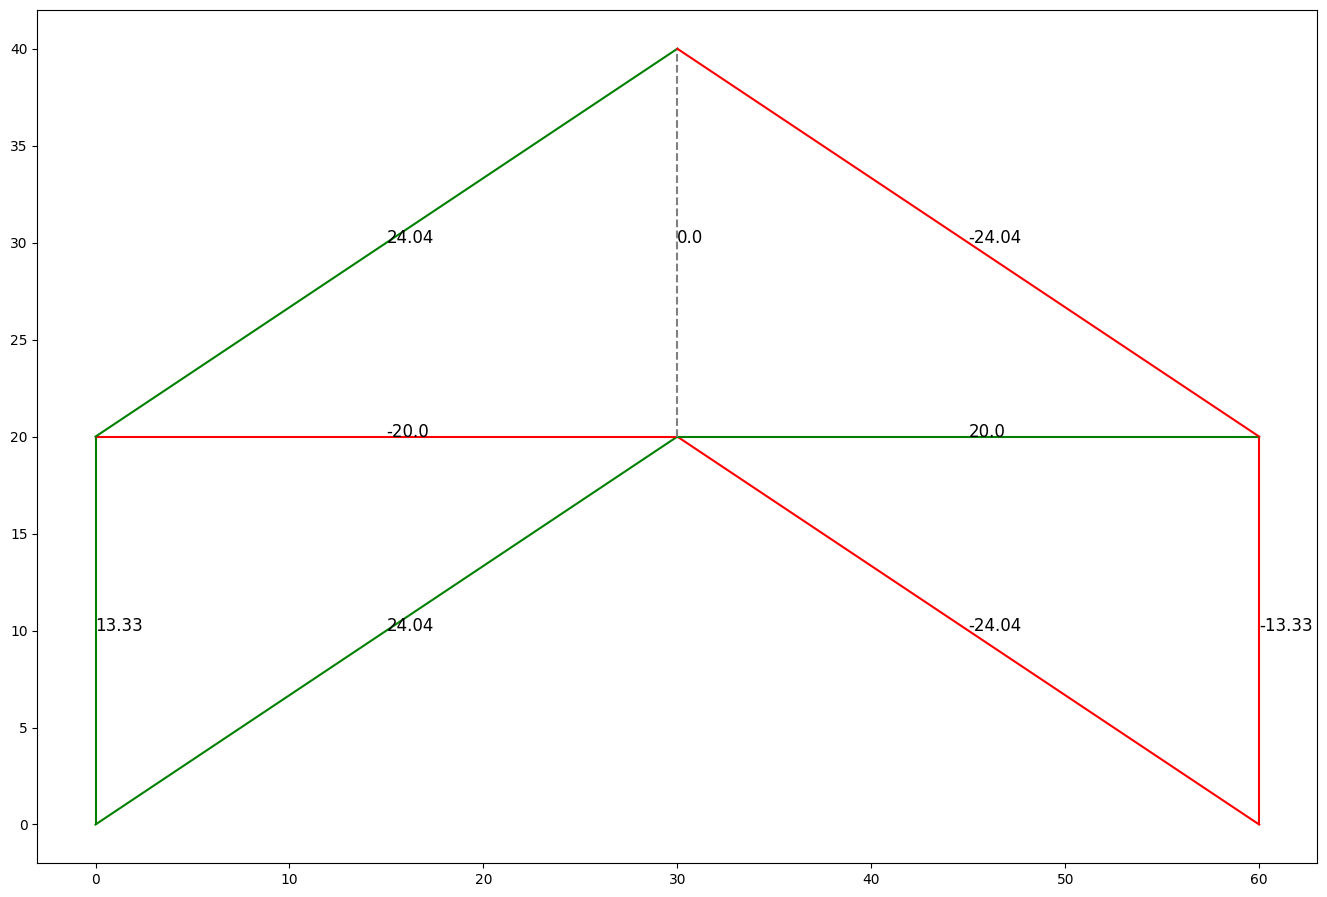

In [114]:
numberOfDecimals = 2

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal',adjustable='box')

for key, value in dataEdges.items():
    xi = value["coordinates"]["xi"]
    yi = value["coordinates"]["yi"]
    xj = value["coordinates"]["xj"]
    yj = value["coordinates"]["yj"]
    if (abs(value['solved']['fuerzaInterna'])<0.001):
        axes.plot([xi, xj], [yi, yj], "grey",linestyle='--')
    elif value['solved']['fuerzaInterna']>0:
        axes.plot([xi, xj], [yi, yj], "g")
    elif value['solved']['fuerzaInterna']<0:
        axes.plot([xi, xj], [yi, yj], "r")

    roundForce=round(value['solved']['fuerzaInterna'],numberOfDecimals)

    xMid=(xi+xj)/2
    yMid=(yi+yj)/2
    
    axes.text(xMid,yMid,str(roundForce),fontsize=12)

    # print(value['solved']['fuerzaInterna'])


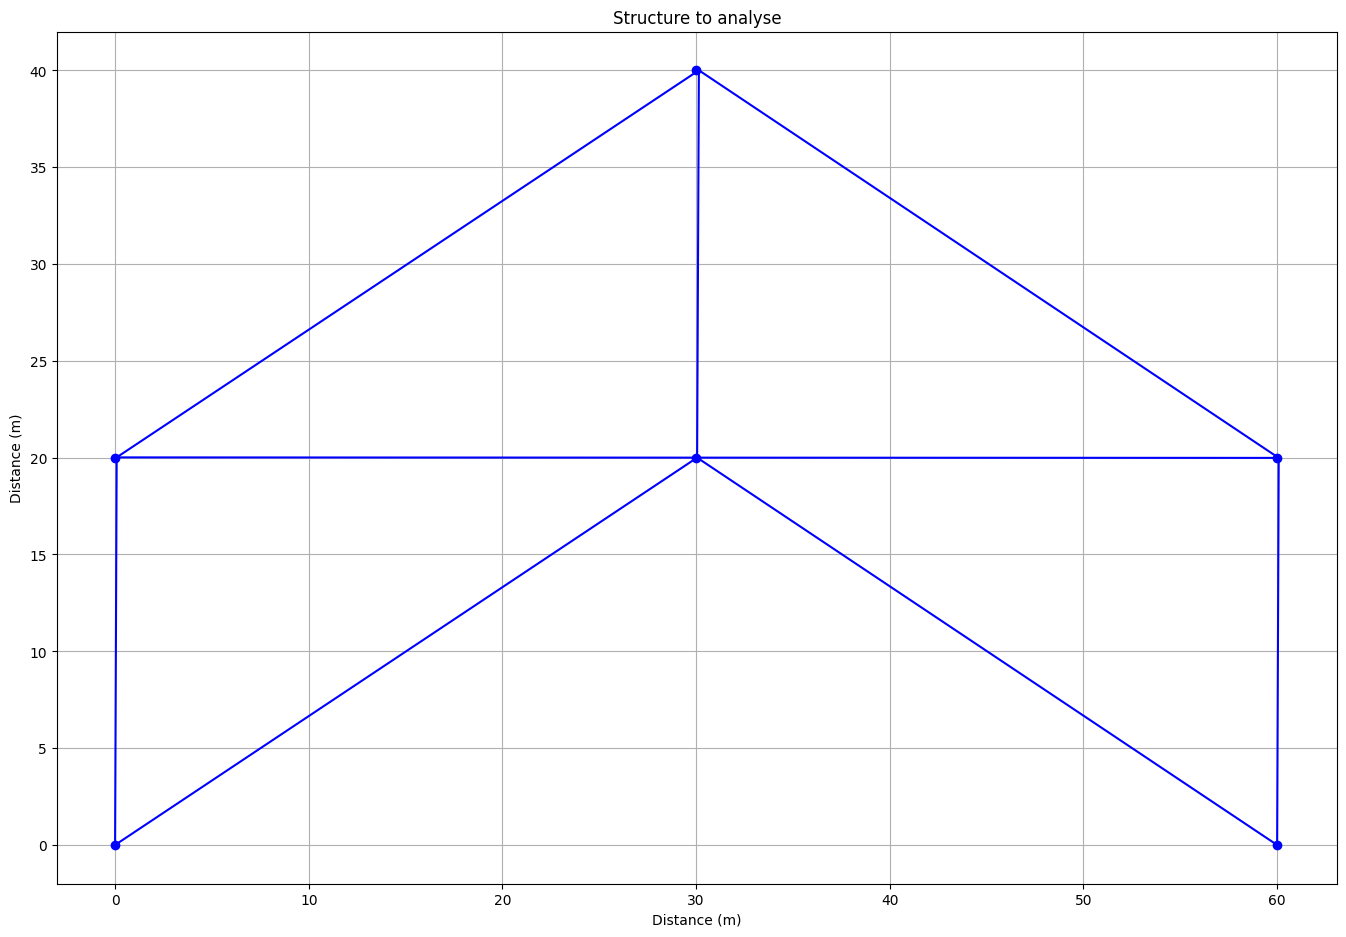

In [115]:
factorScale = 500

esquema = plt.figure()
axes = esquema.add_axes([0.1, 0.1, 2, 2])
esquema.gca().set_aspect('equal',adjustable='box')

for key, value in dataEdges.items():
    xi = value["coordinates"]["xi"] + value["solved"]["displacements"][0] * factorScale
    yi = value["coordinates"]["yi"] + value["solved"]["displacements"][1] * factorScale
    xj = value["coordinates"]["xj"] + value["solved"]["displacements"][2] * factorScale
    yj = value["coordinates"]["yj"] + value["solved"]["displacements"][3] * factorScale
    axes.plot([xi, xj], [yi, yj], "b")
for key, value in dataVertices["data"].items():
    axes.plot([value["coordinates"]["x"]], [value["coordinates"]["y"]], "bo")

axes.set_xlabel("Distance (m)")
axes.set_ylabel("Distance (m)")
axes.set_title("Structure to analyse")
axes.grid()
plt.show()